In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import lightgbm as lgb

In [2]:
# 设定递归特征选择后的分子描述符
selected_features = ['BertzCT', 'Chi2v', 'Chi4n', 'Chi4v', 
                     'SMR_VSA3', 'SMR_VSA9', 'SlogP_VSA8', 
                     'TPSA', 'MolMR', 'fr_NH0']


In [3]:
# 读取数据
df = pd.read_csv(r"D:\回归数据\allpi3k分子描述符内部数据集.csv",encoding = 'gbk')

In [4]:
# 计算摩根指纹
fingerprints = []
for s in df['smiles']:
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        fingerprints.append(None)
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        arr = np.zeros((2048,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fingerprints.append(arr)

df['fingerprint'] = fingerprints
df = df[df['fingerprint'].notnull()].reset_index(drop=True)  # 删除无效 SMILES
fingerprint_array = np.array(df['fingerprint'].tolist())  # 转换为 NumPy 数组

# 提取分子描述符
descriptors = df[selected_features]


[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerator
[14:54:14] DEPRECATION WARNING: please use MorganGenerat

In [5]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 计算 MACCS 指纹
def compute_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        maccs = MACCSkeys.GenMACCSKeys(mol)
        return np.array(maccs)
    else:
        return np.zeros((167,))  # MACCS指纹长度为167

# 计算MACCS指纹数组
maccs_fingerprints = np.array([compute_maccs(smiles) for smiles in df['smiles']])

# 标准化分子描述符
scaler = StandardScaler()
X_scaled = scaler.fit_transform(descriptors)

# 合并摩根指纹、MACCS指纹和标准化的描述符
X_combined = np.hstack([X_scaled, fingerprint_array, maccs_fingerprints])
y = df['pIC50'].values

# 划分数据集（70% 训练, 15% 验证, 15% 测试）
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
# import pickle
# import numpy as np
# import lightgbm as lgb
# import xgboost as xgb
# from sklearn.ensemble import RandomForestRegressor, StackingRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score, mean_squared_error

# # --------------------------
# # 假设 X_train, y_train, X_val, y_val, X_test, y_test, scaler, selected_features 已经定义
# # 如果需要，可以将训练集和验证集合并，用于最终模型的训练
# X_train_full = np.concatenate([X_train, X_val])
# y_train_full = np.concatenate([y_train, y_val])

# # --------------------------
# # 定义各个基学习器（使用 scikit-learn API）
# # --------------------------
# # LightGBM 模型
# lgb_reg = lgb.LGBMRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     num_leaves=31,
#     max_depth=5,
#     reg_alpha=0.1,          # 对应 lambda_l1
#     reg_lambda=0.2,         # 对应 lambda_l2
#     min_child_samples=20,   # 对应 min_data_in_leaf
#     random_state=42
# )

# # XGBoost 模型
# xgb_reg = xgb.XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=5,
#     reg_alpha=0.1,          # L1 正则化
#     reg_lambda=0.2,         # L2 正则化
#     objective='reg:squarederror',
#     random_state=42
# )

# # 随机森林模型
# rf_model = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=10,
#     random_state=42
# )

# # 将原来的线性回归替换为 KNN 模型
# knn_model = KNeighborsRegressor()  # 可根据需要调整参数，例如 n_neighbors

# # --------------------------
# # 使用 Stacking 集成各个基学习器
# # --------------------------
# # 这里采用线性回归作为元学习器，也可以根据需要选择其它模型
# stacking_reg = StackingRegressor(
#     estimators=[
#         ('lgb', lgb_reg),
#         ('xgb', xgb_reg),
#         ('rf', rf_model),
#         ('knn', knn_model)
#     ],
#     final_estimator=LinearRegression(),
#     cv=5,
#     n_jobs=-1
# )

# # --------------------------
# # 训练 stacking 模型
# # --------------------------
# stacking_reg.fit(X_train_full, y_train_full)

# # --------------------------
# # 模型评估函数
# # --------------------------
# def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
#     y_train_pred = model.predict(X_train)
#     y_val_pred = model.predict(X_val)
#     y_test_pred = model.predict(X_test)
#     print(f"==== {name} Performance ====")
#     print(f"Train  R²: {r2_score(y_train, y_train_pred):.3f} | Train  MSE: {mean_squared_error(y_train, y_train_pred):.3f}")
#     print(f"Valid  R²: {r2_score(y_val, y_val_pred):.3f} | Valid  MSE: {mean_squared_error(y_val, y_val_pred):.3f}")
#     print(f"Test   R²: {r2_score(y_test, y_test_pred):.3f} | Test   MSE: {mean_squared_error(y_test, y_test_pred):.3f}")
#     print("\n")

# # --------------------------
# # 分别评估各个单模型（基学习器）在原训练集、验证集和测试集上的表现
# # --------------------------
# # 注意：由于 stacking 集成中，各模型的训练是在 stacking 内部完成，这里单独评估时，
# # 我们直接调用各模型的 fit 方法得到的基模型预测效果（基于 X_train_full 训练）。
# lgb_reg.fit(X_train_full, y_train_full)
# evaluate_model("LightGBM", lgb_reg, X_train, y_train, X_val, y_val, X_test, y_test)

# xgb_reg.fit(X_train_full, y_train_full)
# evaluate_model("XGBoost", xgb_reg, X_train, y_train, X_val, y_val, X_test, y_test)

# rf_model.fit(X_train_full, y_train_full)
# evaluate_model("Random Forest", rf_model, X_train, y_train, X_val, y_val, X_test, y_test)

# knn_model.fit(X_train_full, y_train_full)
# evaluate_model("KNN", knn_model, X_train, y_train, X_val, y_val, X_test, y_test)

# # --------------------------
# # 评估 Stacking 集成模型
# # --------------------------
# evaluate_model("Stacking Ensemble", stacking_reg, X_train, y_train, X_val, y_val, X_test, y_test)

# # --------------------------
# # 保存模型及预处理对象
# # --------------------------
# model_dict = {
#     'stacking_model': stacking_reg,
#     'scaler': scaler,
#     'selected_features': selected_features
# }
# model_path = "stacking_regression_model.pkl"
# with open(model_path, 'wb') as f:
#     pickle.dump(model_dict, f)
# print(f"Models saved to {model_path}")


In [9]:
# --------------------------
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# 正则化参数优化示例（LightGBM）
params = {
    'lambda_l1': 0.1,     # L1正则化强度
    'lambda_l2': 0.2,     # L2正则化强度 
    'min_data_in_leaf': 20, # 叶节点最小样本数
    'max_depth': 5         # 限制树深度
}
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'verbose': -1,
#     'seed': 42
# }

# 设置回调函数，包含提前停止和日志打印
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True),
             lgb.log_evaluation(10)]

# --------------------------
# 训练 LightGBM 模型
# --------------------------
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

# --------------------------
# 模型评估
# --------------------------
# 训练集评估
y_train_pred = lgb_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
print("==== Training Performance ====")
print(f"R²: {r2_train:.3f}")
print(f"MSE: {mse_train:.3f}")

# 验证集评估
y_val_pred = lgb_model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
print("==== Validation Performance ====")
print(f"R²: {r2_val:.3f}")
print(f"MSE: {mse_val:.3f}")

# 测试集评估
y_test_pred = lgb_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("==== Test Performance ====")
print(f"R²: {r2_test:.3f}")
print(f"MSE: {mse_test:.3f}")

# --------------------------
# 保存模型及预处理对象
# --------------------------
model_dict = {
    'lgb_model': lgb_model,
    'scaler': scaler,
    'selected_features': selected_features
}
model_path = "lightgbm_regression_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model_dict, f)
print(f"Model saved to {model_path}")

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5816
[LightGBM] [Info] Number of data points in the train set: 7284, number of used features: 1824
[LightGBM] [Warning] Provided parameters con

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # 添加MAE的导入

# 训练集评估
y_train_pred = lgb_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)  # 新增MAE计算
print("==== Training Performance ====")
print(f"R²: {r2_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"MAE: {mae_train:.4f}")  # 新增MAE输出

# 验证集评估
y_val_pred = lgb_model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)  # 新增MAE计算
print("==== Validation Performance ====")
print(f"R²: {r2_val:.4f}")
print(f"MSE: {mse_val:.4f}")
print(f"MAE: {mae_val:.4f}")  # 新增MAE输出

# 测试集评估
y_test_pred = lgb_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)  # 新增MAE计算
print("==== Test Performance ====")
print(f"R²: {r2_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"MAE: {mae_test:.4f}")  # 新增MAE输出

==== Training Performance ====
R²: 0.8506
MSE: 0.2249
MAE: 0.3574
==== Validation Performance ====
R²: 0.7017
MSE: 0.4550
MAE: 0.4974
==== Test Performance ====
R²: 0.6977
MSE: 0.4579
MAE: 0.4995


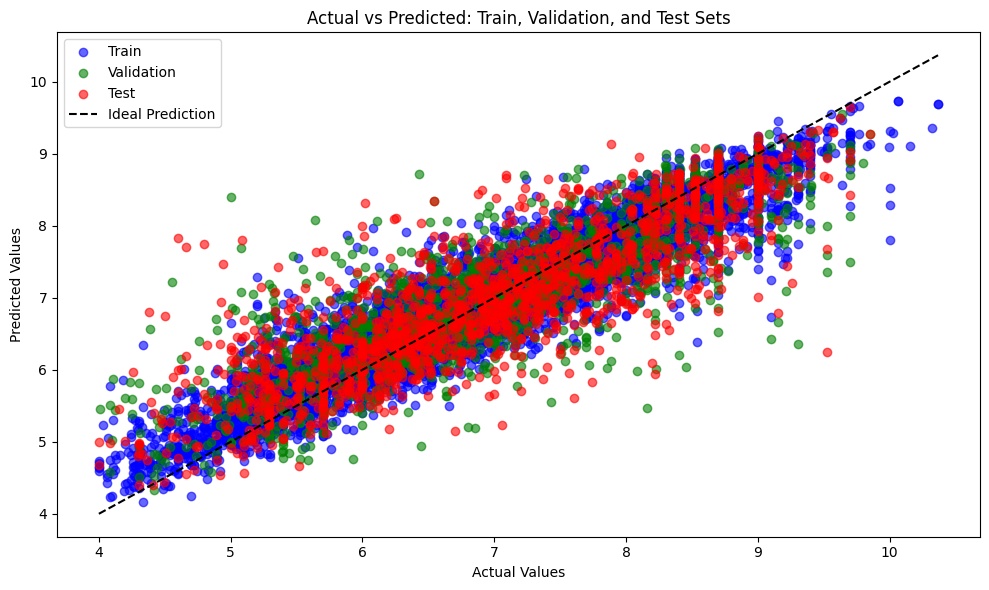

Scatter plot saved to D:\图数据\lgb回归actual_vs_predicted_scatter_plot.png
Prediction data saved to CSV files


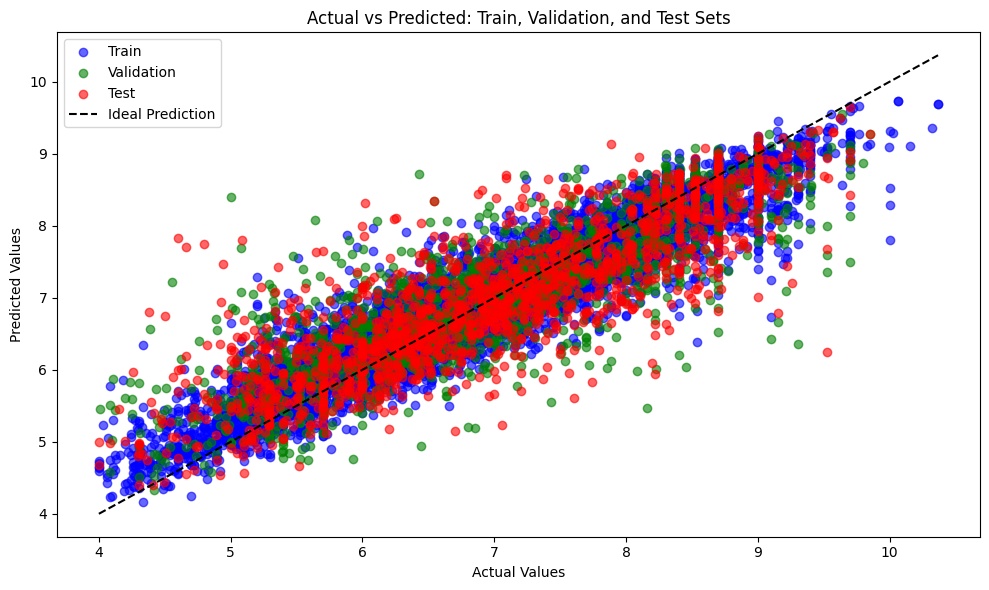

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# 绘制散点图
# --------------------------

# 将训练集、验证集和测试集的实际值与预测值存入DataFrame
train_data_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
val_data_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred})
test_data_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# 绘制散点图
plt.figure(figsize=(10, 6))

# 训练集散点图
plt.scatter(train_data_df['Actual'], train_data_df['Predicted'], color='blue', label='Train', alpha=0.6)
# 验证集散点图
plt.scatter(val_data_df['Actual'], val_data_df['Predicted'], color='green', label='Validation', alpha=0.6)
# 测试集散点图
plt.scatter(test_data_df['Actual'], test_data_df['Predicted'], color='red', label='Test', alpha=0.6)

# 添加标题和标签
plt.title('Actual vs Predicted: Train, Validation, and Test Sets')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# 绘制对角线 (y=x线)
plt.plot([min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
         [min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
         color='black', linestyle='--', label='Ideal Prediction')

# 设置图例
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()

# --------------------------
# 保存图像
# --------------------------
output_image_path = "D:\图数据\lgb回归actual_vs_predicted_scatter_plot.png"
plt.figure(figsize=(10, 6))

plt.scatter(train_data_df['Actual'], train_data_df['Predicted'], color='blue', label='Train', alpha=0.6)
plt.scatter(val_data_df['Actual'], val_data_df['Predicted'], color='green', label='Validation', alpha=0.6)
plt.scatter(test_data_df['Actual'], test_data_df['Predicted'], color='red', label='Test', alpha=0.6)

plt.title('Actual vs Predicted: Train, Validation, and Test Sets')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
         [min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
         color='black', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.savefig(output_image_path,dpi=1000)

# --------------------------
# 保存绘图数据为 CSV
# --------------------------
train_data_df.to_csv('D:\图数据\lgb回归train_data_predictions.csv', index=False)
val_data_df.to_csv('D:\图数据\lgb回归val_data_predictions.csv', index=False)
test_data_df.to_csv('D:\图数据\lgb回归test_data_predictions.csv', index=False)

print(f"Scatter plot saved to {output_image_path}")
print("Prediction data saved to CSV files")


In [20]:
# 保存模型及预处理对象
# --------------------------
model_dict = {
    'lgb_model': lgb_model,
    'scaler': scaler,
    'selected_features': selected_features
}
model_path = "lightgbm_regression_model2.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model_dict, f)
print(f"Model saved to {model_path}")

Model saved to lightgbm_regression_model2.pkl


In [13]:
# 外部验证
external_csv = r"D:\回归数据\allpi3k分子描述符外部验证集.csv"
df_ext = pd.read_csv(external_csv, encoding="gbk")

# 计算外部数据的摩根指纹和MACCS指纹
fingerprints_ext = []
maccs_fingerprints_ext = []

for s in df_ext['smiles']:
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        fingerprints_ext.append(None)
        maccs_fingerprints_ext.append(None)
    else:
        # 计算摩根指纹
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        arr_fp = np.zeros((2048,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, arr_fp)
        fingerprints_ext.append(arr_fp)
        
        # 计算MACCS指纹
        maccs = MACCSkeys.GenMACCSKeys(mol)
        arr_maccs = np.array(maccs)
        maccs_fingerprints_ext.append(arr_maccs)

# 过滤掉指纹为空的分子
df_ext['fingerprint'] = fingerprints_ext
df_ext['maccs_fingerprint'] = maccs_fingerprints_ext
df_ext = df_ext[df_ext['fingerprint'].notnull() & df_ext['maccs_fingerprint'].notnull()].reset_index(drop=True)

# 转换为数组
fingerprint_array_ext = np.array(df_ext['fingerprint'].tolist())
maccs_fingerprint_array_ext = np.array(df_ext['maccs_fingerprint'].tolist())

# 提取外部数据的描述符
descriptors_ext = df_ext[selected_features]

# 标准化描述符
descriptors_ext_scaled = scaler.transform(descriptors_ext)

# 合并摩根指纹、MACCS指纹和标准化描述符
X_combined_ext = np.hstack([descriptors_ext_scaled, fingerprint_array_ext, maccs_fingerprint_array_ext])

# 预测
y_pred_ext = lgb_model.predict(X_combined_ext)
df_ext['pIC50_pred'] = y_pred_ext

# 外部验证集性能评估
y_ext = df_ext['pIC50']
r2_ext = r2_score(y_ext, y_pred_ext)
mse_ext = mean_squared_error(y_ext, y_pred_ext)
print("==== External validation performance ====")
print(f"R²: {r2_ext:.3f}")
print(f"MSE: {mse_ext:.3f}")

# 保存预测结果
output_file = "external_predictions.csv"
df_ext.to_csv(output_file, index=False)
print(f"External predictions saved to {output_file}")


[16:31:55] DEPRECATION WARNING: please use MorganGenerator
[16:31:55] DEPRECATION WARNING: please use MorganGenerator
[16:31:55] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerator
[16:31:56] DEPRECATION WARNING: please use MorganGenerat

==== External validation performance ====
R²: 0.679
MSE: 0.501
External predictions saved to external_predictions.csv


In [14]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error  # 新增MAE导入



r2_ext = r2_score(y_ext, y_pred_ext)
mse_ext = mean_squared_error(y_ext, y_pred_ext)
mae_ext = mean_absolute_error(y_ext, y_pred_ext)  # 新增MAE计算

print("==== External validation performance ====")
print(f"R²: {r2_ext:.4f}")
print(f"MSE: {mse_ext:.4f}")
print(f"MAE: {mae_ext:.4f}")  # 新增MAE输出

==== External validation performance ====
R²: 0.6787
MSE: 0.5008
MAE: 0.5160


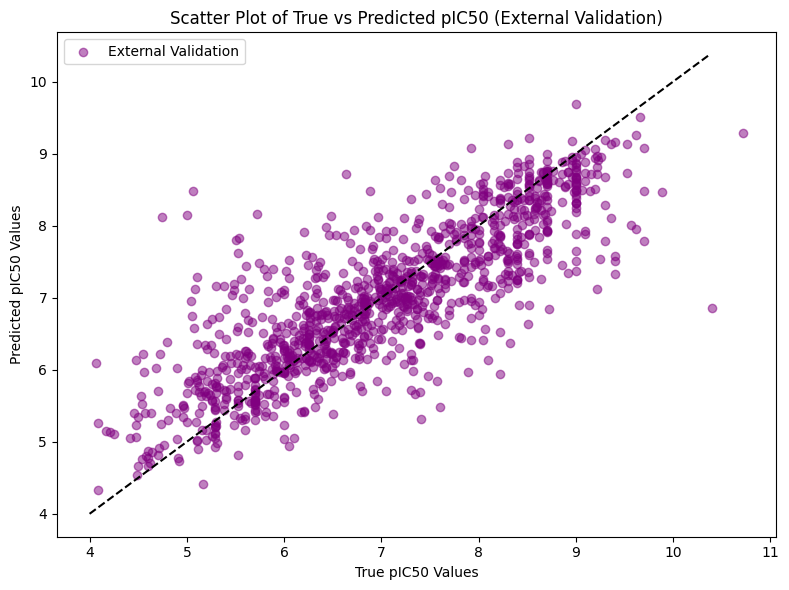

Scatter plot saved to D:\图数据\lgb回归external_validation_scatter.png
Scatter plot data saved to external_validation_scatter_data.csv


In [24]:
# ==========================
# 绘制外部验证集散点图
plt.figure(figsize=(8, 6))
plt.scatter(df_ext['pIC50'], df_ext['pIC50_pred'], color='purple', alpha=0.5, label='External Validation')

# 添加标签和标题
plt.xlabel('True pIC50 Values')
plt.ylabel('Predicted pIC50 Values')
plt.title('Scatter Plot of True vs Predicted pIC50 (External Validation)')
plt.legend()

# 绘制对角线 (y=x线)
plt.plot([min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
         [min(y_train.min(), y_val.min(), y_test.min()), max(y_train.max(), y_val.max(), y_test.max())],
         color='black', linestyle='--', label='Ideal Prediction')
# 保存图像
plt.tight_layout()
output_image_path = "D:\图数据\lgb回归external_validation_scatter.png"
plt.savefig(output_image_path, dpi=300)  # 保存为高分辨率图片
plt.show()

# 保存绘图数据到 CSV
df_ext[['smiles', 'pIC50', 'pIC50_pred']].to_csv('D:\图数据\lgb回归external_validation_scatter_data.csv', index=False)

print(f"Scatter plot saved to {output_image_path}")
print("Scatter plot data saved to external_validation_scatter_data.csv")

In [18]:
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# ============================
# 天然产物预测
natural_product_csv = r"D:\天然产物数据库\天然产物3-去空smiles.csv"
df_np = pd.read_csv(natural_product_csv, encoding="gbk")

# 计算天然产物数据的摩根指纹和MACCS指纹
fingerprints_np = []
maccs_fingerprints_np = []

for s in df_np['smiles']:
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        fingerprints_np.append(None)
        maccs_fingerprints_np.append(None)
    else:
        # 计算摩根指纹
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        arr_fp = np.zeros((2048,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, arr_fp)
        fingerprints_np.append(arr_fp)

        # 计算MACCS指纹
        maccs = MACCSkeys.GenMACCSKeys(mol)
        arr_maccs = np.array(maccs)
        maccs_fingerprints_np.append(arr_maccs)

# 过滤掉指纹为空的分子
df_np['fingerprint'] = fingerprints_np
df_np['maccs_fingerprint'] = maccs_fingerprints_np
df_np = df_np[df_np['fingerprint'].notnull() & df_np['maccs_fingerprint'].notnull()].reset_index(drop=True)

# 转换为数组
fingerprint_array_np = np.array(df_np['fingerprint'].tolist())
maccs_fingerprint_array_np = np.array(df_np['maccs_fingerprint'].tolist())

# 提取天然产物数据的描述符
def calculate_descriptors(mol):
    """Calculate molecular descriptors using RDKit."""
    if mol is None:
        return None
    descriptors = {}
    for desc_name in selected_features:
        try:
            desc_value = Descriptors.__getattr__(desc_name)(mol)
            descriptors[desc_name] = desc_value
        except AttributeError:
            descriptors[desc_name] = np.nan
    return descriptors

# 计算并存储描述符
selected_features = ['BertzCT', 'Chi2v', 'Chi4n', 'Chi4v', 'SMR_VSA3', 'SMR_VSA9', 'SlogP_VSA8', 'TPSA', 'MolMR', 'fr_NH0']
descriptors_list = []

for s in df_np['smiles']:
    mol = Chem.MolFromSmiles(s)
    descriptors = calculate_descriptors(mol)
    if descriptors is not None:
        descriptors_list.append(descriptors)
    else:
        descriptors_list.append({feature: np.nan for feature in selected_features})

# 将描述符转换为DataFrame
descriptors_df = pd.DataFrame(descriptors_list)

# 合并描述符与原数据
df_np = pd.concat([df_np, descriptors_df], axis=1)

# 标准化描述符
scaler = StandardScaler()
descriptors_np_scaled = scaler.fit_transform(df_np[selected_features])

# 合并摩根指纹、MACCS指纹和标准化描述符
X_combined_np = np.hstack([descriptors_np_scaled, fingerprint_array_np, maccs_fingerprint_array_np])

# 预测天然产物pIC50
y_pred_np = lgb_model.predict(X_combined_np)
df_np['pIC50_pred'] = y_pred_np

# 只保留原有数据和预测的结果
df_output = df_np[['smiles', 'pIC50_pred','编号','中文名称','英文名称','CAS NO'
]]

# 保存天然产物预测结果
output_file_np = r"D:\天然产物的预测\三合一天然产物3.csv"
df_output.to_csv(output_file_np, index=False)
print(f"Natural product predictions saved to {output_file_np}")


[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerator
[14:45:14] DEPRECATION WARNING: please use MorganGenerat

Natural product predictions saved to D:\天然产物的预测\三合一lgb天然产物3.csv


E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
E:\anaconda\envs\AIDrugDesign\lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
